### Welcome to a notebook to help make the plots associated with Project 3

Push this button to open it in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/dopplerchase/ATMS-597-SP-2020/blob/master/ATMS-597-SP-2020-Project-3/MakePlots.ipynb)

### Install some packages we need, and download the repository 

In [13]:
!apt-get -qq install libproj-dev proj-data proj-bin libgeos-dev
!pip install Cython
!pip install --upgrade --force-reinstall shapely --no-binary shapely
!pip install cartopy
!pip install netCDF4
!pip install cmocean

!git clone https://github.com/dopplerchase/ATMS-597-SP-2020.git

  Using cached https://files.pythonhosted.org/packages/44/ec/4eddbf9d17a917c51fb4ad159aa7137f506681e91ab559cf87d120e1d78d/Shapely-1.7.0.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.0
    Uninstalling Shapely-1.7.0:
      Successfully uninstalled Shapely-1.7.0
    Running setup.py install for shapely ... done
Cloning into 'ATMS-597-SP-2020'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 351 (delta 27), reused 0 (delta 0), pack-reused 299
Receiving objects: 100% (351/351), 5.79 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (171/171), done.


### load modules 

In [19]:
import pandas as pd
import cmocean
import xarray as xr
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


### load files 

In [0]:
date_file = './ATMS-597-SP-2020/ATMS-597-SP-2020-Project-3/data/precip_gte95quant.csv'
dates_gte_95 = pd.read_csv(date_file, 
                           header=None, parse_dates=[1], index_col=[1]).index
daily_select_mean = xr.open_dataset('./ATMS-597-SP-2020/ATMS-597-SP-2020-Project-3/data/daily_select_mean.nc', engine='netcdf4')
daily_select_std = xr.open_dataset('./ATMS-597-SP-2020/ATMS-597-SP-2020-Project-3/data/daily_select_std.nc', engine='netcdf4')
ltm_JJA_mean = xr.open_dataset('./ATMS-597-SP-2020/ATMS-597-SP-2020-Project-3/data/ltm_JJA_mean.nc', engine='netcdf4')

In [21]:
#add bulk shear 
u = ltm_JJA_mean.uwnd_500 - ltm_JJA_mean.uwnd_surf
v = ltm_JJA_mean.vwnd_500 - ltm_JJA_mean.vwnd_surf
shear = np.sqrt(u**2 - v**2)
ltm_JJA_mean['bulk_shear'] = shear

/usr/local/lib/python3.6/dist-packages/xarray/core/computation.py:601: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [0]:
# calc seasonal anomaly fields
seasonal_anomaly = (daily_select_mean - ltm_JJA_mean)/daily_select_std

### import mapping stuff!

In [0]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import cartopy.feature as cfeature

crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

def plot_background(ax):
    ax.set_extent([235., 290., 20., 55.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

### Synoptic Dynamics. 

Where is upper level divergence-convergence, mid layer PVA


/usr/local/lib/python3.6/dist-packages/cartopy/mpl/geoaxes.py:1833: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


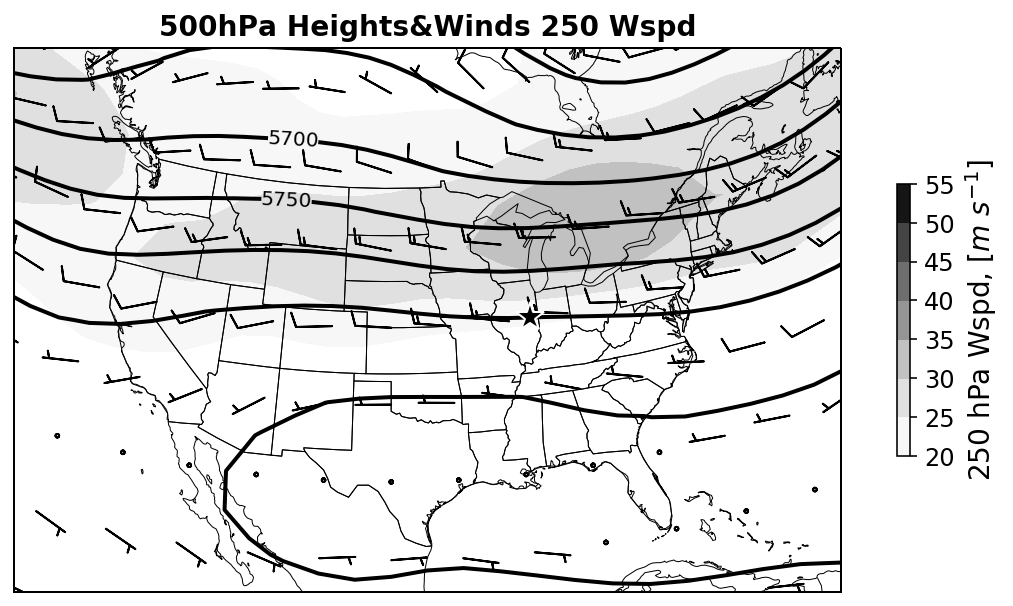

In [27]:
fig = plt.figure(figsize=(10,5))
fig.set_facecolor('w')
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
lon = (360.-88.2434)
lat = 40.1164
# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(daily_select_mean['lon'].values, daily_select_mean['lat'])
pm = ax.contourf(lon_2d, lat_2d,daily_select_mean['wspd_250'], levels=np.arange(20,60,5),cmap='Greys', transform=ccrs.PlateCarree(),)
c1 = ax.contour(lon_2d, lat_2d, daily_select_mean['hgt_500'], levels=np.arange(4900,6200,50),colors='black', linewidths=2,
                       transform=ccrs.PlateCarree())
ax.clabel(c1, fontsize=10, inline=1, inline_spacing=5, fmt='%i', rightside_up=True)
ax.plot(lon,lat,'*', transform=ccrs.PlateCarree(),color='w',markerfacecolor='k',ms=15)
ax.barbs(lon_2d[::2,::2],lat_2d[::2,::2],daily_select_mean['uwnd_500'].values[::2,::2],daily_select_mean['vwnd_500'].values[::2,::2],transform=ccrs.PlateCarree(),length=6,sizes={'emptybarb':0.05,})
cbar = plt.colorbar(pm,ax=ax,shrink=0.5)
cbar.set_label('250 hPa Wspd, [$m\ s^{-1}$]',fontsize=14)
cbar.ax.tick_params(labelsize=12)
ax.set_title('500hPa Heights&Winds 250 Wspd',fontsize=14,fontweight='bold')

plt.tight_layout()

plt.savefig('95thpercentile_Champaign_500heights_250wspd.png',dpi=300)

### Check the Surface Parameters 

/usr/local/lib/python3.6/dist-packages/cartopy/mpl/geoaxes.py:1833: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


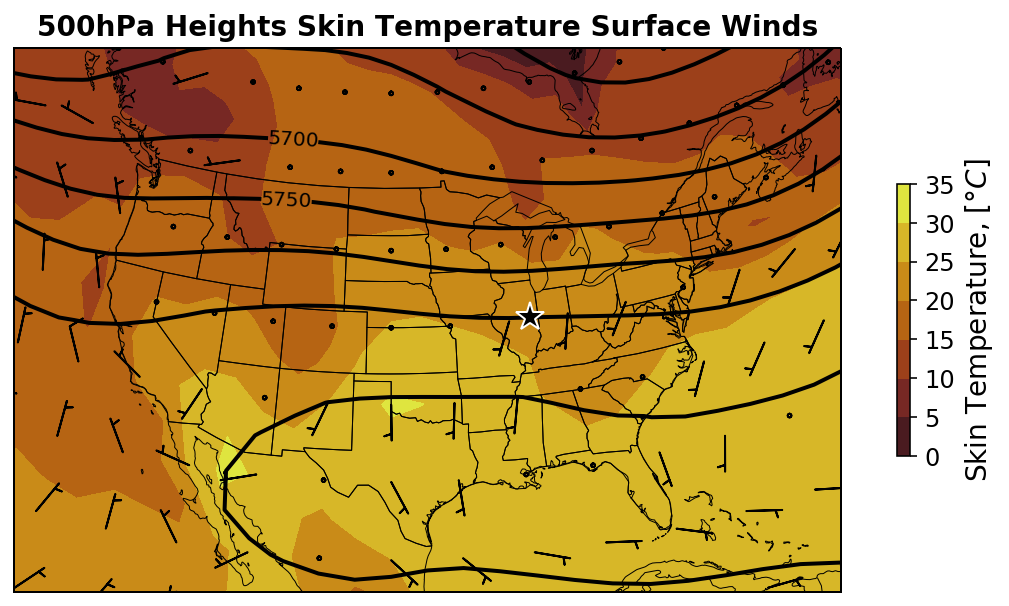

In [28]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
lon = (360.-88.2434)
lat = 40.1164
# Combine 1D latitude and longitudes into a 2D grid of locations
pm = ax.contourf(lon_2d, lat_2d,daily_select_mean['temp_skin']-273,levels=np.arange(0,40,5),cmap=cmocean.cm.solar, transform=ccrs.PlateCarree(),)
c1 = ax.contour(lon_2d, lat_2d, daily_select_mean['hgt_500'], levels=np.arange(4900,6200,50),colors='black', linewidths=2,
                       transform=ccrs.PlateCarree())
ax.clabel(c1, fontsize=10, inline=1, inline_spacing=5, fmt='%i', rightside_up=True)
ax.barbs(lon_2d[::2,::2],lat_2d[::2,::2],daily_select_mean['uwnd_surf'].values[::2,::2],daily_select_mean['vwnd_surf'].values[::2,::2],transform=ccrs.PlateCarree(),length=6,sizes={'emptybarb':0.05,})
ax.plot(lon,lat,'*', transform=ccrs.PlateCarree(),color='w',markerfacecolor='k',ms=15)
cbar = plt.colorbar(pm,ax=ax,shrink=0.5)
cbar.set_label('Skin Temperature, [$\degree{C}$]',fontsize=14)
cbar.ax.tick_params(labelsize=12)
ax.set_title('500hPa Heights Skin Temperature Surface Winds',fontsize=14,fontweight='bold')
plt.tight_layout()

plt.savefig('95thpercentile_Champaign_500heights_SkinT_SurfaceWinds.png',dpi=300)

### What about 850 moisture and winds 

/usr/local/lib/python3.6/dist-packages/cartopy/mpl/geoaxes.py:1833: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


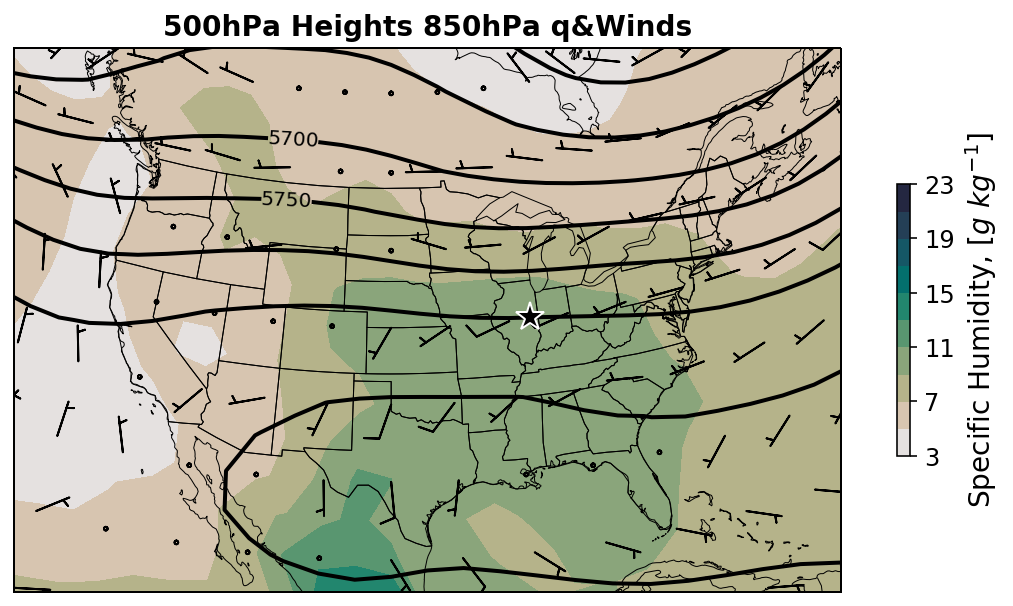

In [29]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
lon = (360.-88.2434)
lat = 40.1164
# Combine 1D latitude and longitudes into a 2D grid of locations
pm = ax.contourf(lon_2d, lat_2d,daily_select_mean['shum_850']*1000,levels=np.arange(3,24,2),cmap=cmocean.cm.rain, transform=ccrs.PlateCarree(),)
c1 = ax.contour(lon_2d, lat_2d, daily_select_mean['hgt_500'], levels=np.arange(4900,6200,50),colors='black', linewidths=2,
                       transform=ccrs.PlateCarree())
ax.clabel(c1, fontsize=10, inline=1, inline_spacing=5, fmt='%i', rightside_up=True)
ax.barbs(lon_2d[::2,::2],lat_2d[::2,::2],daily_select_mean['uwnd_850'].values[::2,::2],daily_select_mean['vwnd_850'].values[::2,::2],transform=ccrs.PlateCarree(),length=6,sizes={'emptybarb':0.05,})
ax.plot(lon,lat,'*', transform=ccrs.PlateCarree(),color='w',markerfacecolor='k',ms=15)
cbar = plt.colorbar(pm,ax=ax,shrink=0.5)
cbar.set_label('Specific Humidity, [$g\ kg^{-1}$]',fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax.set_title('500hPa Heights 850hPa q&Winds',fontsize=14,fontweight='bold')

plt.tight_layout()

plt.savefig('95thpercentile_Champaign_500heights_850q_and_Winds.png',dpi=300)

### Lets look at total precip water and deep layer sheer

/usr/local/lib/python3.6/dist-packages/cartopy/mpl/geoaxes.py:1833: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


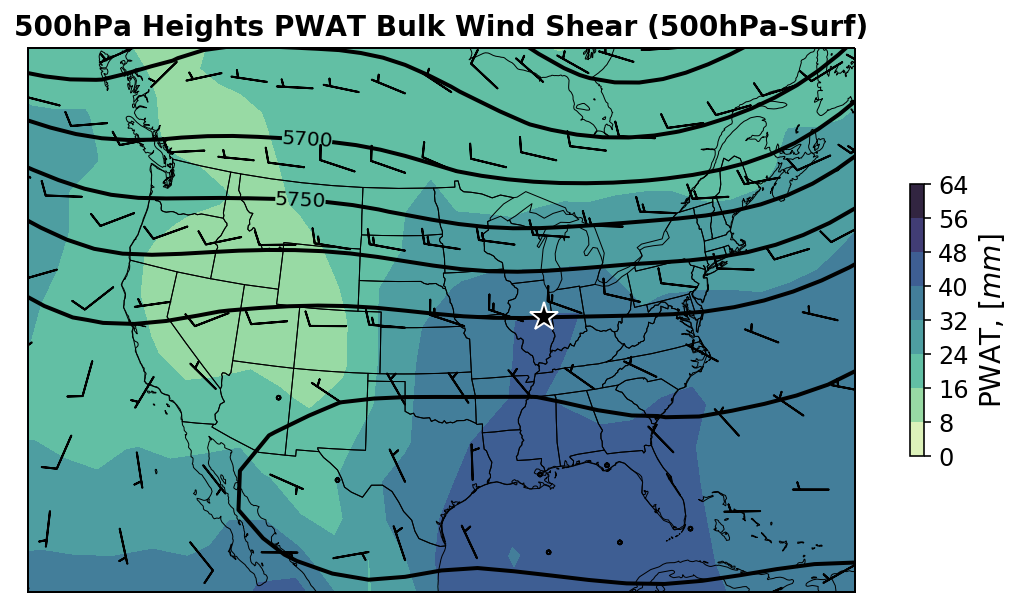

In [30]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
lon = (360.-88.2434)
lat = 40.1164
# Combine 1D latitude and longitudes into a 2D grid of locations
pm = ax.contourf(lon_2d, lat_2d,daily_select_mean['t_col_aq'],levels=np.arange(0,65,8),cmap=cmocean.cm.deep, transform=ccrs.PlateCarree(),)
c1 = ax.contour(lon_2d, lat_2d, daily_select_mean['hgt_500'], levels=np.arange(4900,6200,50),colors='black', linewidths=2,
                       transform=ccrs.PlateCarree())
ax.clabel(c1, fontsize=10, inline=1, inline_spacing=5, fmt='%i', rightside_up=True)
ax.barbs(lon_2d[::2,::2],lat_2d[::2,::2],daily_select_mean['uwnd_500'].values[::2,::2]-daily_select_mean['uwnd_surf'].values[::2,::2],daily_select_mean['vwnd_500'].values[::2,::2]-daily_select_mean['vwnd_surf'].values[::2,::2],transform=ccrs.PlateCarree(),length=6,sizes={'emptybarb':0.05,})
ax.plot(lon,lat,'*', transform=ccrs.PlateCarree(),color='w',markerfacecolor='k',ms=15)
cbar = plt.colorbar(pm,ax=ax,shrink=0.5)
cbar.set_label('PWAT, [$mm$]',fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax.set_title('500hPa Heights PWAT Bulk Wind Shear (500hPa-Surf)',fontsize=14,fontweight='bold')

plt.tight_layout()
plt.savefig('95thpercentile_Champaign_500heights_BulkShear_PWAT.png',dpi=300)

#### Anomaly Analysis 

14


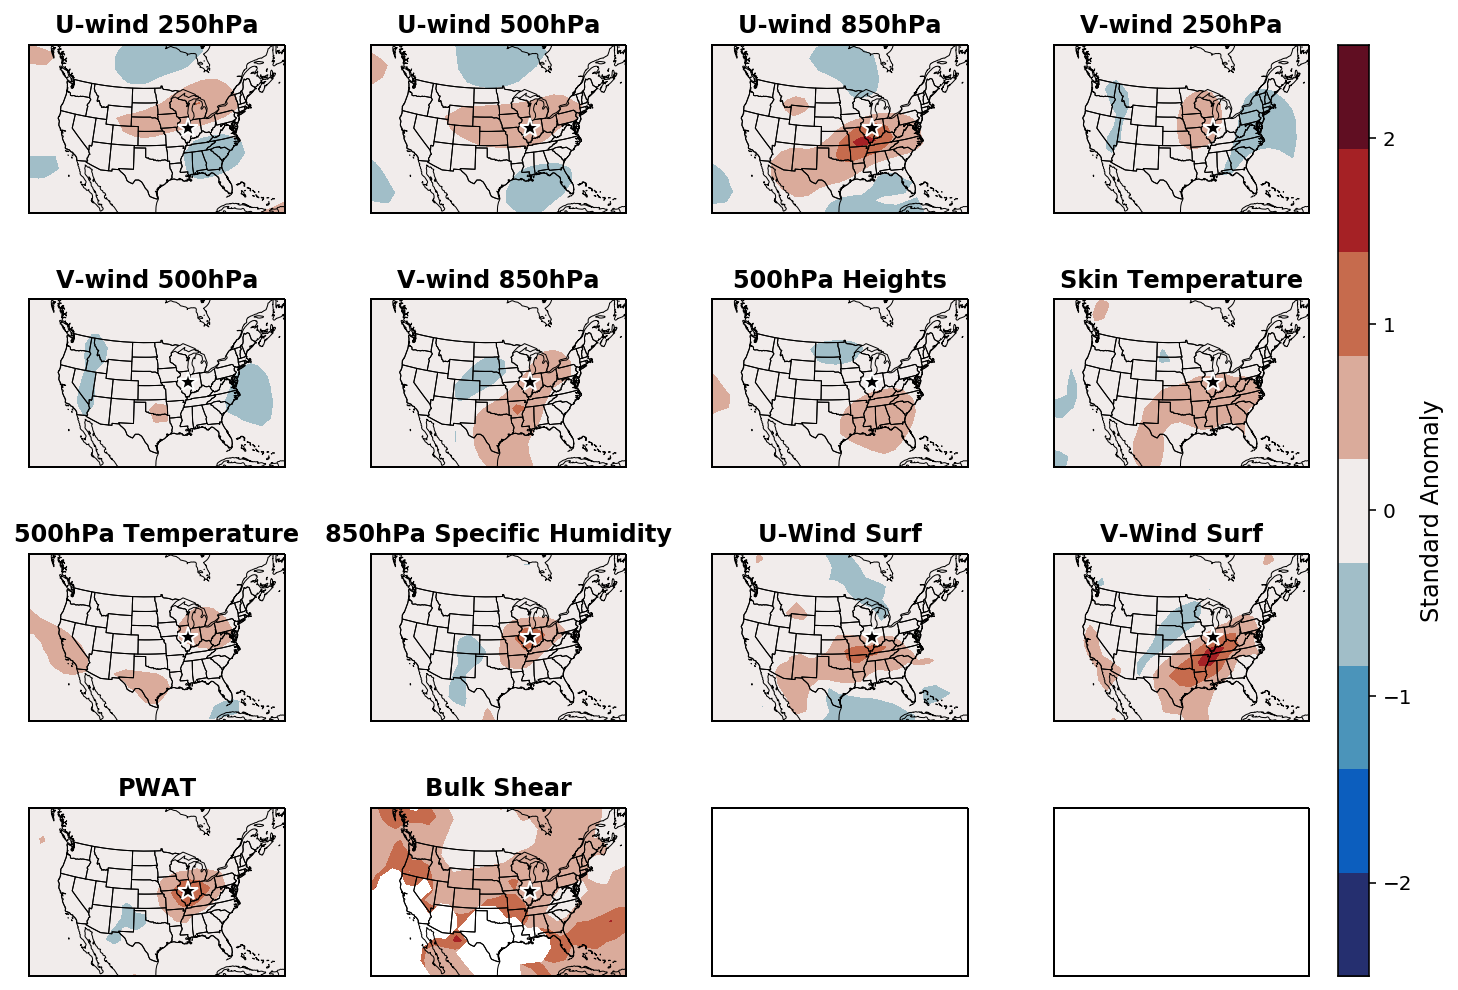

In [32]:
projection = crs
axes_class = (GeoAxes,
              dict(map_projection=projection))

l = list(seasonal_anomaly.variables)
l.remove('lat')
l.remove('lon')
 
print(len(l))
fig = plt.figure(figsize=(12,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(4, 4),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode
title_list = ['U-wind 250hPa','U-wind 500hPa','U-wind 850hPa', 'V-wind 250hPa','V-wind 500hPa','V-wind 850hPa','500hPa Heights','Skin Temperature','500hPa Temperature','850hPa Specific Humidity','U-Wind Surf','V-Wind Surf','PWAT','Bulk Shear']
for i, ax in enumerate(axgr):

    if i >= 14:
      ax.axis('off')
    else:
      ax.set_extent([235., 290., 20., 55.])
      ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
      ax.add_feature(cfeature.STATES, linewidth=0.5)
      ax.add_feature(cfeature.BORDERS, linewidth=0.5)
      p = ax.contourf(lon_2d, lat_2d,seasonal_anomaly[l[i]],levels=np.linspace(-2.5,2.5,10),transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,vmin=-2.5,vmax=2.5)
      ax.plot(lon,lat,'*', transform=ccrs.PlateCarree(),color='w',markerfacecolor='k',ms=10)
      ax.set_title(title_list[i],fontsize=12,fontweight='bold')

cbar = axgr.cbar_axes[0].colorbar(p)
cbar.set_label_text('Standard Anomaly',fontsize=12)
# cbar.ax.tick_params(labelsize=12)

plt.savefig('95thpercentile_Champaign_Anoms.png',dpi=300)
plt.show()

